##### Packages

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

c:\Users\vebky\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Processing

In [5]:
data = pd.read_csv("C:/Users/vebky/FIE458/termpaper/Cleaned_Data.csv")
data.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,0,acs crypto,crims switch de-fi police trace crypto crimes ...,1,"[725437, 492541, 1102845, 437298, 885216, 6438...","[138, 161, 38, 90, 289, 0, 289, 7, 38, 282, 13..."
1,1,acs crypto,welcome aircentralstation join aircentralstati...,1,"[194583, 30197, 407032, 30197, 1413970, 109968...","[7, 155, 31, 138, 24, 90, 155, 0, 50, 38, 161,..."
2,2,adaf,this zesty faucet from @_bitcoiner making twee...,1,"[1310907, 843491, 224679, 1221500, 84711, 1099...","[282, 178, 38, 289, 0, 237, 155, 289, 282, 72,..."
3,3,adaf,@bondwolfie . all doctors are fatphobic world ...,1,"[0, 1044714, 1433243, 945028, 45136, 1021170, ...","[3, 230, 24, 6, 10, 7, 24, 31, 212, 38, 155, 0..."
4,4,adaf,@umezawa_ honestly idk. might make sense check...,1,"[571361, 454028, 878217, 1044714, 595598, 1148...","[3, 198, 90, 155, 237, 50, 7, 50, 53, 0, 178, ..."


#### Balanced Data

In [6]:
# Sample a subset of the data, 50000 rows, which is 50% scam=1 and 50% scam=0
bal = data.groupby('Scam').apply(lambda x: x.sample(25000, random_state=1)).reset_index(drop=True)
bal.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,236830,hedera,auction klaxon! only six hours left these two ...,0,"[1164211, 695772, 781942, 437276, 94468, 63273...","[50, 198, 138, 282, 38, 24, 6, 0, 239, 31, 50,..."
1,218583,fantom,hyped for 2022 with this amazing hector team j...,0,"[1037456, 986965, 1270237, 526037, 1310907, 98...","[178, 72, 300, 155, 10, 0, 212, 24, 161, 0, 18..."
2,276366,mina,🤷🏾‍♂️🤷🏾‍♂️🤷🏾‍♂️ thank you !! @mithisa_motho yo...,0,"[652624, 672369, 652624, 672369, 652624, 67236...","[0, 0, 0, 0, 100, 0, 0, 0, 0, 100, 0, 0, 0, 0,..."
3,231603,gnosis,"@dihuaflute the , they might well while we're ...",0,"[0, 586665, 43212, 1048353, 595598, 791932, 37...","[3, 10, 38, 178, 198, 50, 212, 31, 198, 282, 1..."
4,364445,thorchain,@akurypto @ but #rune dead @akurypto @ that’s ...,0,"[1121754, 695055, 486027, 540467, 386209, 1121...","[3, 50, 239, 198, 161, 72, 300, 282, 24, 0, 3,..."


In [4]:
# number of unique entries in "Scam" column and the count of each
bal['Scam'].value_counts()

0    25000
1    25000
Name: Scam, dtype: int64

#### Unbalanced Data

In [5]:
# Sample a subset of the data, 50000 rows
unbal = data.apply(lambda x: x.sample(25000, random_state=1)).reset_index(drop=True)
unbal.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,299782,pancakeswap,@terry265 @ @essentialesc @moonscan @coinlisti...,0,"[339491, 695055, 307718, 1018756, 1382421, 114...","[3, 282, 155, 161, 161, 72, 187, 295, 54, 0, 3..."
1,226913,flow,#nowplaying frank nitti/coco therapy morning ...,0,"[833118, 720732, 610204, 139641, 1042138, 1349...","[172, 6, 24, 7, 300, 31, 50, 72, 38, 6, 5, 0, ..."
2,313233,quant,swing ticker ticker.52 ticker ticker.29 ticker...,0,"[819299, 862855, 862855, 1044714, 106115, 8628...","[289, 7, 38, 6, 5, 0, 282, 38, 138, 239, 155, ..."
3,97290,thodex,"𝐁𝐓𝐂-𝐓𝐑𝐘 𝐄𝐗𝐂𝐇𝐀𝐍𝐆𝐄 𝐑𝐀𝐓𝐄𝐒: btcturk: 47,747.00 try...",1,"[294790, 258985, 821046, 275066, 173398, 27506...","[0, 0, 0, 247, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,332405,stacks,never play duos. find too easy you only have d...,0,"[1076143, 859171, 1390548, 1044714, 1202051, 9...","[6, 155, 266, 155, 161, 0, 300, 31, 50, 72, 0,..."


In [6]:
unbal['Scam'].value_counts()

0    18821
1     6179
Name: Scam, dtype: int64

## Dictionaries

#### Sourcing Text

In [7]:
# Change dataframe if you want balanced/unbalanced data
text = bal['Text'].values
vocabSize = 2000

#### Bag of Words: Words

In [8]:
BagOfWords = CountVectorizer(max_features=vocabSize, stop_words='english')
BOW = BagOfWords.fit_transform(text)
print(BagOfWords.get_feature_names_out())

['00' '000' '00000012' ... '𝐄𝐗𝐂𝐇𝐀𝐍𝐆𝐄' '𝐑𝐀𝐓𝐄𝐒' '𝐓𝐑𝐘']


#### Bag of Words: Ngrams

In [9]:
CharNgrams = CountVectorizer(analyzer='char', ngram_range=(1, 2), max_features=vocabSize)
CHAR = CharNgrams.fit_transform(text)
# print contents of CharNgrams
print(CharNgrams.get_feature_names_out())

[' ' ' !' ' "' ... '🟢🟢' '🤣' '🤣🤣']


#### Bag of Words: TF-IDF

In [10]:
TF_IDF = TfidfVectorizer(max_features=vocabSize, stop_words='english')
tfIDF = TF_IDF.fit_transform(text)
# print the whole of TF_IDF
print(TF_IDF.get_feature_names_out())

['00' '000' '00000012' ... '𝐄𝐗𝐂𝐇𝐀𝐍𝐆𝐄' '𝐑𝐀𝐓𝐄𝐒' '𝐓𝐑𝐘']


#### Selecting the Dictionary

In [11]:
# create function to select dictionary type
def selectDict(name):
    DictList = {'BOW': BOW, 'CHAR': CHAR, 'tfIDF': tfIDF}
    if name in DictList:
        X = DictList[name]
        return X
    else:
        print('Invalid dictionary name')

Once this section is complete, there is no need to rerun it, unless changes to the data is made.

#### Creating Test Sets

In [12]:
# selecting X and Y (change dataframe as you did above)
X = selectDict('tfIDF') # List: BOW, CHAR, tfIDF
Y = bal['Scam'].values

In [13]:
# creating randomly selected balanced training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [14]:
# dimensions of training and validation sets
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(40000, 2000)
(10000, 2000)
(40000,)
(10000,)


In [15]:
# Convert the sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Reshape the input data to have an additional dimension (channels)
X_train_reshaped = np.expand_dims(X_train_dense, axis=-1)
X_val_reshaped = np.expand_dims(X_val_dense, axis=-1)

Callback functions to gather batch-based statistics.

In [3]:
# Callback to log variation of loss within each epoch
class BatchLossCallback(Callback):
    def __init__(self):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Callback to log variation of accuracy within each epoch
class BatchAccuracyCallback(Callback):
    def __init__(self):
        self.batch_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_accuracies.append(logs.get('accuracy'))


## CNN Model

#### Legacy Models

##### CNN2

In [15]:
# Architecture, functional API
CNN2input = layers.Input(shape=(X_train_reshaped.shape[1], 1))
CNN2conv = layers.Conv1D(128, 5, activation=gelu, padding='same')(CNN2input)
CNN2drop = layers.Dropout(0.01)(CNN2conv)
CNN2pool = layers.MaxPooling1D()(CNN2drop)
CNN2flat = layers.Flatten()(CNN2pool)
CNN2dense = layers.Dense(128, activation="relu")(CNN2flat)
CNN2dense2 = layers.Dense(32, activation="relu")(CNN2dense)
CNN2output = layers.Dense(1, activation="sigmoid")(CNN2dense2)

# Create the model
CNN2 = Model(inputs=CNN2input, outputs=CNN2output)

In [17]:
# optimizers and callbacks
CNN2opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bloss2 = BatchLossCallback()
bacc2 = BatchAccuracyCallback()
earlystop = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)
cblist = [earlystop, bloss2, bacc2]

# Compile the model
CNN2.compile(loss='binary_crossentropy', optimizer=CNN2opt, metrics=['accuracy'])
CNN2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2000, 128)         768       
                                                                 
 dropout (Dropout)           (None, 2000, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 128)               16384128  
                                                             

In [18]:
CNN2hist = CNN2.fit(X_train_reshaped, 
                    Y_train, 
                    epochs=5, 
                    validation_data=(X_val_reshaped, Y_val), 
                    batch_size=40, 
                    callbacks=cblist)

Epoch 1/5
1000/1000 [==============================] - 329s 328ms/step - loss: 0.3115 - accuracy: 0.8558 - val_loss: 0.2728 - val_accuracy: 0.8752
Epoch 2/5
1000/1000 [==============================] - 326s 326ms/step - loss: 0.2171 - accuracy: 0.9036 - val_loss: 0.2577 - val_accuracy: 0.8851
Epoch 3/5
1000/1000 [==============================] - 327s 327ms/step - loss: 0.1451 - accuracy: 0.9403 - val_loss: 0.2779 - val_accuracy: 0.8812
Epoch 3: early stopping


In [19]:
# Evaluate the model
lossCNN2, accCNN2 = CNN2.evaluate(X_val_reshaped, Y_val)
print(f"Validation loss: {lossCNN2}, accuracy: {accCNN2}")

313/313 [==============================] - 16s 52ms/step - loss: 0.2577 - accuracy: 0.8851
Validation loss: 0.2576669454574585, accuracy: 0.8851000070571899


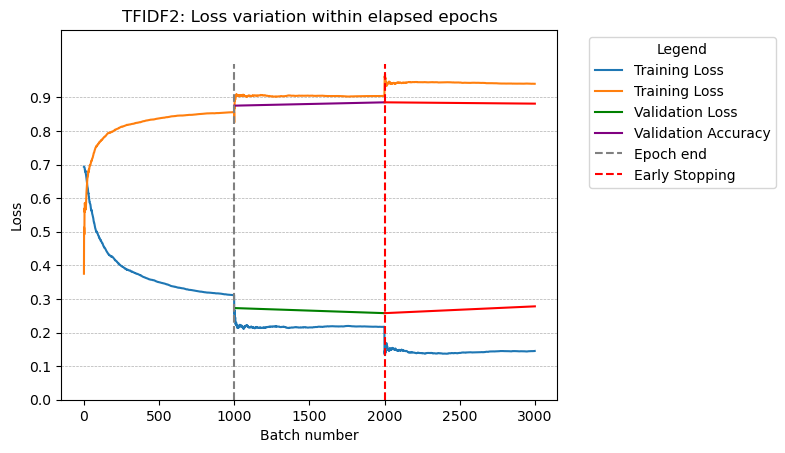

In [56]:
# Plot the batch-wise loss variation within the epoch
plt.plot(np.arange(len(bloss2.batch_losses)), bloss2.batch_losses, label='Training Loss')
# Plot the batch-wise accuracy variation within the epochs
plt.plot(np.arange(len(bacc2.batch_accuracies)), bacc2.batch_accuracies, label='Training Loss')

# draw line sbetween the points
plt.plot([1000, 2000], [CNN2hist.history['val_loss'][0], CNN2hist.history['val_loss'][1]], color='green', label='Validation Loss')
plt.plot([2000, 3000], [CNN2hist.history['val_loss'][1], CNN2hist.history['val_loss'][2]], color='red')

plt.plot([1000, 2000], [CNN2hist.history['val_accuracy'][0], CNN2hist.history['val_accuracy'][1]], color='purple', label='Validation Accuracy')
plt.plot([2000, 3000], [CNN2hist.history['val_accuracy'][1], CNN2hist.history['val_accuracy'][2]], color='red')
# y limit
plt.ylim(0, 1.1)

# Lines
plt.yticks(np.arange(0, 1, 0.1))
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed', label='Epoch end')
plt.vlines(2000, 0, 1, colors='red', linestyles='dashed', label = 'Early Stopping')

plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.title(f'TFIDF2: Loss variation within elapsed epochs')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

plt.show()

In [51]:
XvalDen2 = X_val.todense()
ypred2 = CNN2.predict(XvalDen2)
yclasspred2 = np.round(ypred2).astype(int)
cm2 = confusion_matrix(Y_val, yclasspred2)
print(cm2)

313/313 [==============================] - 17s 55ms/step
[[4531  469]
 [ 680 4320]]


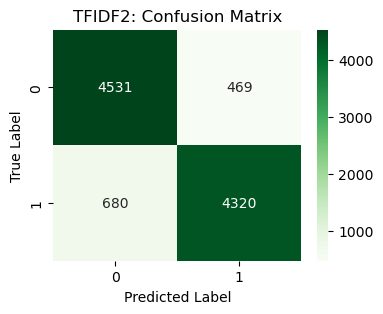

In [57]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TFIDF2: Confusion Matrix')
plt.show()

##### CNN3

In [20]:
# Architecture, functional API
CNN3IP = layers.Input(shape=(X_train_reshaped.shape[1], 1))
CNN3CNV = layers.Conv1D(128, 5, activation=gelu, padding='same')(CNN3IP)
CNN3drop = layers.Dropout(0.01)(CNN3CNV)
CNN3pool = layers.MaxPooling1D()(CNN3drop)
CNN3flat = layers.Flatten()(CNN3pool)
CNN3dense = layers.Dense(128, activation=gelu)(CNN3flat)
CNN3drop2 = layers.Dropout(0.01)(CNN3dense)
CNN3dense2 = layers.Dense(32, activation=gelu)(CNN3drop2)
CNN3drop3 = layers.Dropout(0.01)(CNN3dense2)
CNN3output = layers.Dense(1, activation="sigmoid")(CNN3drop3)

# Create the model
CNN3 = Model(inputs=CNN3IP, outputs=CNN3output)

In [21]:
CNN3opt = tf.keras.optimizers.Adam()
bloss3 = BatchLossCallback()
bacc3 = BatchAccuracyCallback()
earlystop3 = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)
cblist3 = [earlystop3, bloss3, bacc3]
CNN3.compile(loss='binary_crossentropy', optimizer=CNN3opt, metrics=['accuracy'])
CNN3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 128)         768       
                                                                 
 dropout_1 (Dropout)         (None, 2000, 128)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               16384128  
                                                           

In [22]:
CNN3hist = CNN3.fit(X_train_reshaped,
                    Y_train, 
                    epochs=5, 
                    validation_data=(X_val_reshaped, Y_val), 
                    batch_size=40, 
                    callbacks=cblist3)

Epoch 1/5
1000/1000 [==============================] - 311s 311ms/step - loss: 0.3077 - accuracy: 0.8567 - val_loss: 0.2755 - val_accuracy: 0.8728
Epoch 2/5
1000/1000 [==============================] - 311s 311ms/step - loss: 0.2323 - accuracy: 0.8943 - val_loss: 0.2663 - val_accuracy: 0.8785
Epoch 3/5
1000/1000 [==============================] - 320s 320ms/step - loss: 0.1861 - accuracy: 0.9170 - val_loss: 0.2751 - val_accuracy: 0.8813
Epoch 4/5
1000/1000 [==============================] - 326s 326ms/step - loss: 0.1246 - accuracy: 0.9467 - val_loss: 0.3436 - val_accuracy: 0.8837
Epoch 5/5
1000/1000 [==============================] - 326s 326ms/step - loss: 0.0641 - accuracy: 0.9757 - val_loss: 0.3952 - val_accuracy: 0.8749
Epoch 5: early stopping


In [23]:
# Evaluate the model
lossCNN3, accCNN3 = CNN3.evaluate(X_val_reshaped, Y_val)
print(f"Validation loss: {lossCNN3}, accuracy: {accCNN3}")

313/313 [==============================] - 16s 52ms/step - loss: 0.3436 - accuracy: 0.8837
Validation loss: 0.34362947940826416, accuracy: 0.8837000131607056


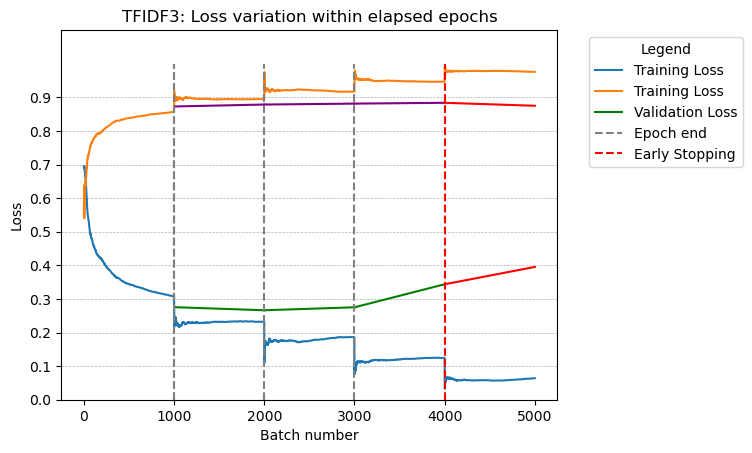

In [44]:
# Plot the batch-wise loss variation within the epoch
plt.plot(np.arange(len(bloss3.batch_losses)), bloss3.batch_losses, label='Training Loss')
# Plot the batch-wise accuracy variation within the epochs
plt.plot(np.arange(len(bacc3.batch_accuracies)), bacc3.batch_accuracies, label='Training Loss')

# draw line sbetween the points
plt.plot([1000, 2000], [CNN3hist.history['val_loss'][0], CNN3hist.history['val_loss'][1]], color='green', label='Validation Loss')
plt.plot([2000, 3000], [CNN3hist.history['val_loss'][1], CNN3hist.history['val_loss'][2]], color='green')
plt.plot([3000, 4000], [CNN3hist.history['val_loss'][2], CNN3hist.history['val_loss'][3]], color='green')
plt.plot([4000, 5000], [CNN3hist.history['val_loss'][3], CNN3hist.history['val_loss'][4]], color='red')



plt.plot([1000, 2000], [CNN3hist.history['val_accuracy'][0], CNN3hist.history['val_accuracy'][1]], color='purple')
plt.plot([2000, 3000], [CNN3hist.history['val_accuracy'][1], CNN3hist.history['val_accuracy'][2]], color='purple')
plt.plot([3000, 4000], [CNN3hist.history['val_accuracy'][2], CNN3hist.history['val_accuracy'][3]], color='purple')
plt.plot([4000, 5000], [CNN3hist.history['val_accuracy'][3], CNN3hist.history['val_accuracy'][4]], color='red')


#xlim is 3000
plt.ylim(0, 1.1)

# Lines
plt.yticks(np.arange(0, 1, 0.1))
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed', label='Epoch end')
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(2000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(3000, 0, 1, colors='gray', linestyles='dashed')
plt.vlines(4000, 0, 1, colors='red', linestyles='dashed', label = 'Early Stopping')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.title(f'TFIDF3: Loss variation within elapsed epochs')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

plt.show()

In [47]:
XvalDen3 = X_val.todense()
ypred3 = CNN2.predict(XvalDen3)
yclasspred3 = np.round(ypred3).astype(int)
cm3 = confusion_matrix(Y_val, yclasspred3)
print(cm3)

313/313 [==============================] - 17s 55ms/step
[[4531  469]
 [ 680 4320]]


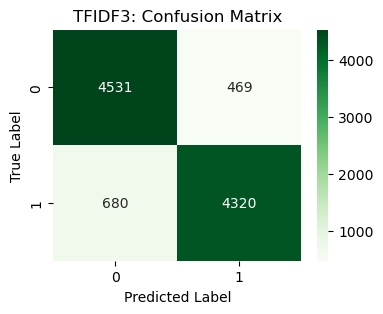

In [50]:
# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TFIDF3: Confusion Matrix')
plt.show()

### Iteration 3.5

##### Model Architecture

In [31]:
# Functional API
# Input layer
inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

#Convolutional layer
conv1 = layers.Conv1D(128, 5, activation=gelu, padding='same')(inputLayer)
max_pool1 = layers.MaxPooling1D()(conv1)
drop1 = layers.Dropout(0.01)(max_pool1)

#Dense Layer
flatten = layers.Flatten()(drop1)
dense = layers.Dense(128, activation=gelu)(flatten)
drop2 = layers.Dropout(0.01)(dense)
bnorm1 = layers.BatchNormalization()(drop2)
dense2 = layers.Dense(32, activation=gelu)(bnorm1)
bnorm2 = layers.BatchNormalization()(dense2)
dense3 = layers.Dense(16, activation=gelu)(bnorm2)
drop3 = layers.Dropout(0.01)(dense3)

#Output
output = layers.Dense(1, activation="sigmoid")(drop3)

# Create the model
model = Model(inputs=inputLayer, outputs=output)

In [32]:
# Optimiser
optimizer = tf.optimizers.Adam()


# Callbacks
batch_loss_callback = BatchLossCallback()
batch_accuracy_callback = BatchAccuracyCallback()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)

# Create a list of callbacks
callbacks_list = [early_stopping, batch_loss_callback, batch_accuracy_callback]

In [33]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2000, 1)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2000, 128)         768       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 1000, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 128000)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               16384128  
                                                           

##### Performance, Metrics, Plots

History

In [34]:
# Train the model
history = model.fit(X_train_reshaped, Y_train, epochs=5, validation_data=(X_val_reshaped, Y_val), batch_size=40, callbacks=callbacks_list)

Epoch 1/5
1000/1000 [==============================] - 285s 284ms/step - loss: 0.3180 - accuracy: 0.8543 - val_loss: 0.3275 - val_accuracy: 0.8409
Epoch 2/5
1000/1000 [==============================] - 286s 286ms/step - loss: 0.2343 - accuracy: 0.8946 - val_loss: 0.5989 - val_accuracy: 0.8377
Epoch 2: early stopping


Performance Plot

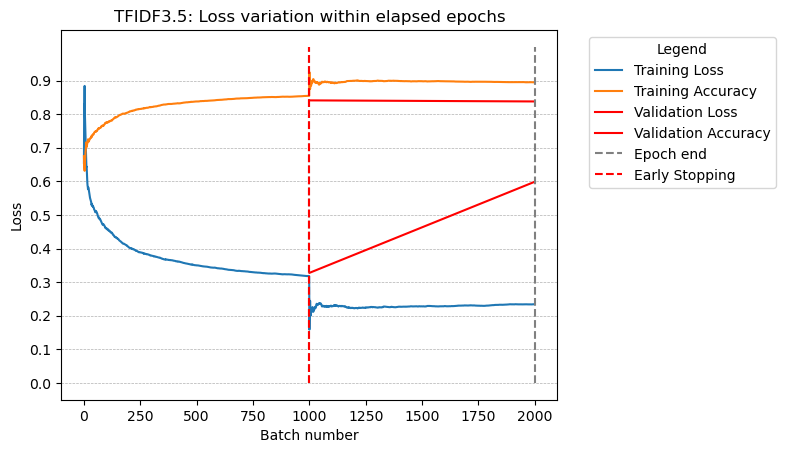

In [65]:
# Plot the batch-wise loss variation within the epoch
plt.plot(np.arange(len(batch_loss_callback.batch_losses)), batch_loss_callback.batch_losses, label='Training Loss')
# Plot the batch-wise accuracy variation within the epochs
plt.plot(np.arange(len(batch_accuracy_callback.batch_accuracies)), batch_accuracy_callback.batch_accuracies, label='Training Accuracy')

# draw line sbetween the points
plt.plot([1000, 2000], [history.history['val_loss'][0], history.history['val_loss'][1]], color='red', label='Validation Loss')

plt.plot([1000, 2000], [history.history['val_accuracy'][0], history.history['val_accuracy'][1]], color='red', label='Validation Accuracy')

# Lines
plt.yticks(np.arange(0, 1, 0.1))
plt.vlines(1000, 0, 1, colors='gray', linestyles='dashed', label='Epoch end')
plt.vlines(1000, 0, 1, colors='red', linestyles='dashed', label = 'Early Stopping')
plt.vlines(2000, 0, 1, colors='gray', linestyles='dashed')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.title(f'TFIDF3.5: Loss variation within elapsed epochs')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Legend')

plt.show()

Evaluation

In [61]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val_reshaped, Y_val)
print(f"Validation loss: {loss}, accuracy: {accuracy}")

313/313 [==============================] - 17s 54ms/step - loss: 0.3275 - accuracy: 0.8409
Validation loss: 0.32752084732055664, accuracy: 0.8409000039100647


Confusion Matrix

In [62]:
# Convert the sparse input data to dense format
X_val_dense = X_val.todense()

# Get the model's predictions on the dense validation set
y_pred = model.predict(X_val_dense)

313/313 [==============================] - 16s 51ms/step


In [63]:
y_pred_classes = np.round(y_pred).astype(int)  # For binary classification

[[4001  999]
 [ 592 4408]]


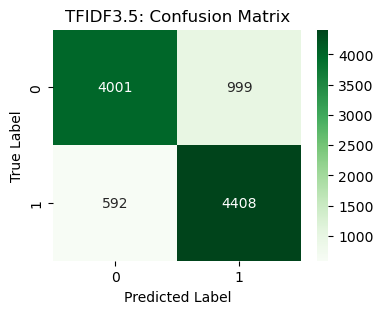

In [64]:
# Compute the confusion matrix
cm = confusion_matrix(Y_val, y_pred_classes)
print(cm)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TFIDF3.5: Confusion Matrix')
plt.show()

### BOWCNN2: Functional Convolutional Layers, Adam Optimizer

Input layer

    inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

Convolutional layer

    conv1 = layers.Conv1D(128, 5, activation=gelu)(inputLayer)

    drop1 = layers.Dropout(0.01)(conv1)

MaxPooling layer

    max_pool = layers.MaxPooling1D()(drop1)

Dense Layer

    flatten = layers.Flatten()(max_pool)

    dense = layers.Dense(128, activation=gelu)(flatten)
    
    dense2 = layers.Dense(32, activation=gelu)(dense)

Output
    output = layers.Dense(1, activation="sigmoid")(dense2)

Create the model

    model = Model(inputs=inputLayer, outputs=output)

Compile the model

    optimizer = Adam(learning_rate=0.001)

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### BOWCNN3: Functional Convolutional Layers, Rectified Adam Optimizer


Input layer

    inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

Convolutional layer

    conv1 = layers.Conv1D(128, 3, activation=gelu)(inputLayer)
    drop1 = layers.Dropout(0.01)(conv1)

MaxPooling layer

    max_pool = layers.MaxPooling1D()(drop1)

Dense Layer

    flatten = layers.Flatten()(max_pool)
    dense = layers.Dense(128, activation=gelu)(flatten)
    dense2 = layers.Dense(32, activation=gelu)(dense)

Output

    output = layers.Dense(1, activation="sigmoid")(dense2)

Create the model

    model = Model(inputs=inputLayer, outputs=output)

Optimiser

    optimizer = optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001, weight_decay=0.01)

Callbacks

    batch_loss_callback = BatchLossCallback()

    batch_accuracy_callback = BatchAccuracyCallback()

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

Create a list of callbacks

    callbacks_list = [early_stopping, batch_loss_callback, batch_accuracy_callback]

Compile the model

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
# Functional API
# Input layer
inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

#Convolutional layer
conv1 = layers.Conv1D(128, 5, activation=gelu, padding='same')(inputLayer)
max_pool1 = layers.MaxPooling1D()(conv1)
drop1 = layers.Dropout(0.01)(max_pool1)

# convolutional layer 2
conv2 = layers.Conv1D(128, 5, activation=gelu, padding='same')(inputLayer)
max_pool2 = layers.MaxPooling1D()(conv2)
drop2 = layers.Dropout(0.01)(max_pool2)

# concat
concat = layers.Concatenate()([drop1, drop2])

#Dense Layer
flatten = layers.Flatten()(concat)
dense = layers.Dense(128, activation=gelu)(flatten)
drop3 = layers.Dropout(0.01)(dense)
bnorm1 = layers.BatchNormalization()(drop3)
dense2 = layers.Dense(32, activation=gelu)(bnorm1)
bnorm2 = layers.BatchNormalization()(dense2)
dense3 = layers.Dense(16, activation=gelu)(bnorm2)
drop4 = layers.Dropout(0.01)(dense3)

#Output
output = layers.Dense(1, activation="sigmoid")(drop3)

# Create the model
model = Model(inputs=inputLayer, outputs=output)

# Optimiser
optimizer = tf.optimizers.Adam()


# Callbacks
batch_loss_callback = BatchLossCallback()
batch_accuracy_callback = BatchAccuracyCallback()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=1, mode='max', restore_best_weights=True)

# Create a list of callbacks
callbacks_list = [early_stopping, batch_loss_callback, batch_accuracy_callback]

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2000, 128)    768         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2000, 128)    768         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1000, 128)    0           ['conv1d[0][0]']                 
                                                                                              